In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset  # 텐서데이터셋
from torch.utils.data import DataLoader  # 데이터로더

device = "cuda" if torch.cuda.is_available() else "cpu"  # 장치 선택

# 입력
X = torch.Tensor([[1], [2], [3], [4], [5], [6], [7], [8]]).to(device)

# 정답
Y = torch.Tensor([[1], [4], [9], [16], [25], [36], [49], [64]]).to(device)

dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


# XOR 모델
class XOR(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(1, 10)
        self.layer2 = torch.nn.Linear(10, 10)
        self.layer3 = torch.nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x


model = XOR().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)

nb_epochs = 10000
for epoch in range(nb_epochs + 1):
    for batch_idx, samples in enumerate(dataloader):
        # print(batch_idx)
        # print(samples)
        x_train, y_train = samples
        # H(x) 계산
        prediction = model(x_train)

        # cost 계산
        cost = F.mse_loss(prediction, y_train)

        # cost로 H(x) 계산
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        print(f'Epoch {epoch:4d}/{nb_epochs} Batch {batch_idx + 1}/{len(dataloader)} Cost: {cost.item():.6f}')
print(f'결과 출력: {model(X)}')

Epoch    0/10000 Batch 1/4 Cost: 2480.323486
Epoch    0/10000 Batch 2/4 Cost: 140.069946
Epoch    0/10000 Batch 3/4 Cost: 1100.863525
Epoch    0/10000 Batch 4/4 Cost: 273.484528
Epoch    1/10000 Batch 1/4 Cost: 2469.063721
Epoch    1/10000 Batch 2/4 Cost: 1090.544434
Epoch    1/10000 Batch 3/4 Cost: 112.226845
Epoch    1/10000 Batch 4/4 Cost: 302.984650
Epoch    2/10000 Batch 1/4 Cost: 302.727112
Epoch    2/10000 Batch 2/4 Cost: 1986.121826
Epoch    2/10000 Batch 3/4 Cost: 575.213623
Epoch    2/10000 Batch 4/4 Cost: 1089.159790
Epoch    3/10000 Batch 1/4 Cost: 269.434753
Epoch    3/10000 Batch 2/4 Cost: 1876.205811
Epoch    3/10000 Batch 3/4 Cost: 136.203491
Epoch    3/10000 Batch 4/4 Cost: 1650.577026
Epoch    4/10000 Batch 1/4 Cost: 35.807503
Epoch    4/10000 Batch 2/4 Cost: 1343.609863
Epoch    4/10000 Batch 3/4 Cost: 104.547447
Epoch    4/10000 Batch 4/4 Cost: 2427.391357
Epoch    5/10000 Batch 1/4 Cost: 1858.777100
Epoch    5/10000 Batch 2/4 Cost: 30.261055
Epoch    5/10000 Batch 

In [5]:
import numpy as np
from gymnasium import Env
from gymnasium import spaces
from gymnasium.spaces import Discrete, Box
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import namedtuple, deque
from numpy.random import default_rng
import matplotlib.pyplot as plt

In [6]:
def generate_time_series(batch_size: int, 
                         n_steps: int) -> torch.Tensor:
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) # 4, 32, 1
    time = np.linspace(0, 1, n_steps) # 50
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # 50
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # 50
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # 32, 50
    return series[..., np.newaxis].astype(np.float32) # 32, 50, 1

In [8]:
n_steps = 50
series = generate_time_series(10_000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

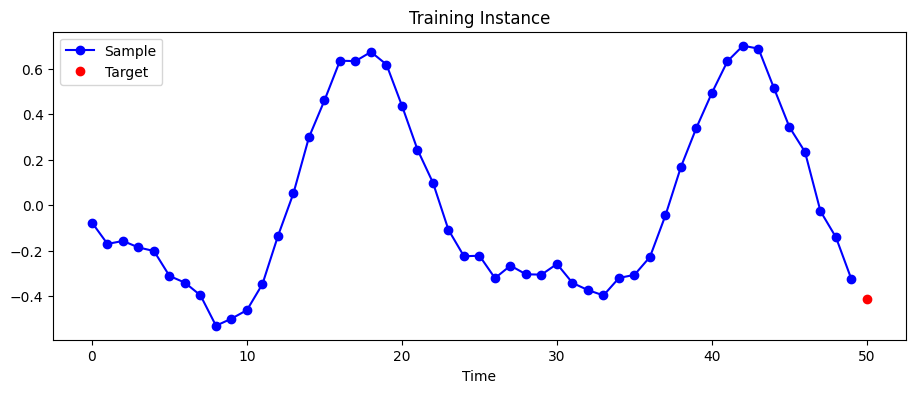

In [5]:
# Plotting the training data
plt.figure(figsize=(11,4))
plt.plot(np.arange(n_steps), X_train[0, ...], "bo-", label="Sample")
plt.plot(np.arange(n_steps, n_steps + 1), y_train[0, ...], "ro", label="Target")
plt.title("Training Instance")
plt.xlabel("Time")
plt.legend(loc="upper left")

In [9]:
# XOR 모델
class XOR(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(1, 10)
        self.layer2 = torch.nn.Linear(10, 10)
        self.layer3 = torch.nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Fully connected neural network with one hidden layer, batch_size=32, n_steps=50
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [12]:
model = FCNN(input_size=50, hidden_size=50, output_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

nb_epochs = 20
for epoch in range(nb_epochs + 1):
    for batch_idx, samples in enumerate(dataloader):
        # print(batch_idx)
        # print(samples)
        x_train, y_train = samples
        # H(x) 계산
        prediction = model(x_train)

        # cost 계산
        cost = F.mse_loss(prediction, y_train)

        # cost로 H(x) 계산
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

    print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(dataloader),
        cost.item()
        ))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1600x1 and 50x50)

In [6]:
# Fully connected neural network with one hidden layer to predict the next value in the time series
class Sequential(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Sequential, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [10]:
# Hyperparameters
input_size = 50
hidden_size = 32
output_size = 1
num_epochs = 100
batch_size = 32
learning_rate = 0.01

# Model
model = Sequential(input_size, hidden_size, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    # Convert numpy arrays to torch tensors
    inputs = X_train
    targets = y_train
    
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, num_epochs, loss.item()))
        
# Test the model
with torch.no_grad():
    inputs = torch.from_numpy(X_test)
    targets = torch.from_numpy(y_test)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    print('Test loss: {:.4f}'.format(loss.item()))
    
# Plot the graph
plt.figure(figsize=(11,4))
plt.plot(np.arange(n_steps), X_test[0, ...], "bo-", label="Sample")
plt.plot(np.arange(n_steps, n_steps + 1), y_test[0, ...], "ro", label="Target")
plt.plot(np.arange(n_steps, n_steps + 1), outputs[0, ...], "go", label="Prediction")
plt.title("Test Instance")
plt.xlabel("Time")
plt.legend(loc="upper left")




RuntimeError: mat1 and mat2 shapes cannot be multiplied (350000x1 and 50x32)

In [14]:
class RNN(nn.Module):
    def __init__(self, 
                 input_size: int,
                 output_size: int, 
                 hidden_dim: int,
                 n_layers: int) -> None:
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        # Many inputs to one output
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_dim)

In [15]:
model = RNN(input_size=1, output_size=1, hidden_dim=32, n_layers=1)